In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
from datetime import date, timedelta
np.random.seed(seed=0)
plt.rcParams['text.usetex'] = True

plt.rcParams.update({'font.size': 16})
# plt.rcParams["font.family"] = "Times New Roman"
# sns.set_style("whitegrid", rc={'font.family': 'Times New Roman', 'font.size': 16})
sns.set_style("whitegrid", rc={'font.size': 16})

from constants import LOCATION_CHOOSEN, LOCATION_CHOOSEN_2, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

- Susceptible (S): This should ideally be the total population minus the total cases. So, your calculation seems correct here. However, it's important to note that 'total_cases' includes both currently infected individuals and those who have recovered or died. Therefore, a more accurate calculation might be `df['S'] = df['population'] - df['total_cases']`.

- Infected (I): This should be the current active cases, not the total cases. You might need to calculate this as `df['I'] = df['total_cases'] - df['total_deaths'] - df['people_fully_vaccinated']`.

- Recovered (R): This should include people who have recovered from the disease and those who are vaccinated. If your dataset includes a 'total_recovered' column, you could use that. If not, you might need to estimate it. You could potentially use `df['R'] = df['people_fully_vaccinated'] + df['total_deaths']` (assuming that all who are not currently infected and have not been vaccinated have recovered).

Please note that these are just suggestions and the actual implementation might vary based on the specific details and assumptions of your model. Also, this model does not take into account the natural birth and death in the population. It's a simple model and might not fully capture the complexities of an actual outbreak.

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

In [3]:
df.columns

Index(['date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'gdp_normalized_modelled'],
      dtype='object')

In [4]:
start_date = date(2020, 3, 1)
end_date = date(2022, 11, 1)
delta = timedelta(days=1)

worldometers_dates = []
worldometers_total_cases = []
worldometers_total_recovered = []
worldometers_active_cases = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y%m%d")
    data_path_worldometer = os.path.join(DATA_CACHE_DIR, "worldometer", date_str + ".csv")
    if os.path.exists(data_path_worldometer):
        worldometer_df = pd.read_csv(data_path_worldometer)
        worldometer_df.columns = ['country' if col.startswith('Country') else col for col in worldometer_df.columns]
        worldometer_df.columns = worldometer_df.columns.str.lower().str.replace(' ', '')
        date_data = ""
        total_cases = 0
        total_recovered = 0
        worldometer_df_specified_location = worldometer_df.loc[(worldometer_df["country"].str.lower() == LOCATION_CHOOSEN_2.lower())]
        date_data = date_str[:4] + "-" + date_str[4:6] + "-" + date_str[6:]
        total_cases = 0.0 if math.isnan(worldometer_df_specified_location["totalcases"].item()) else worldometer_df_specified_location["totalcases"].item()
        active_cases = 0.0 if math.isnan(worldometer_df_specified_location["activecases"].item()) else worldometer_df_specified_location["activecases"].item()
        total_recovered = 0.0 if math.isnan(worldometer_df_specified_location["totalrecovered"].item()) else worldometer_df_specified_location["totalrecovered"].item()
        print(date_data, total_cases, total_recovered, type(total_recovered), math.isnan(total_recovered))
        worldometers_dates.append(date_data)
        worldometers_total_cases.append(total_cases)
        worldometers_total_recovered.append(total_recovered)
        worldometers_active_cases.append(active_cases)
    else:
        print(data_path_worldometer, "DOES NOT EXIST -- COLLECT DATA MANUALLY")
    start_date += delta

2020-03-01 3 3.0 <class 'float'> False
2020-03-02 6 3.0 <class 'float'> False
2020-03-03 6 3.0 <class 'float'> False
2020-03-04 28 3.0 <class 'float'> False
2020-03-05 30 3.0 <class 'float'> False
2020-03-06 30 3.0 <class 'float'> False
2020-03-07 34 3.0 <class 'float'> False
2020-03-08 39 3.0 <class 'float'> False
2020-03-09 45 4.0 <class 'float'> False
2020-03-10 47 4.0 <class 'float'> False
2020-03-11 62 4.0 <class 'float'> False
2020-03-12 62 4.0 <class 'float'> False
2020-03-13 82 10.0 <class 'float'> False
2020-03-14 97 10.0 <class 'float'> False
2020-03-15 100 10.0 <class 'float'> False
2020-03-16 114 13.0 <class 'float'> False
2020-03-17 142 14.0 <class 'float'> False
2020-03-18 152 14.0 <class 'float'> False
2020-03-19 197 20.0 <class 'float'> False
2020-03-20 223 23.0 <class 'float'> False
2020-03-21 332 23.0 <class 'float'> False
2020-03-22 332 23.0 <class 'float'> False
2020-03-23 425 24.0 <class 'float'> False
2020-03-24 519 40.0 <class 'float'> False
2020-03-25 606 42.0 <

2020-11-14 8773479 8163572.0 <class 'float'> False
2020-11-15 8814902 8205728.0 <class 'float'> False
2020-11-16 8845617 8249579.0 <class 'float'> False
2020-11-17 8900008 8318778.0 <class 'float'> False
2020-11-18 8912907 8335109.0 <class 'float'> False
2020-11-19 8960098 8383602.0 <class 'float'> False
2020-11-20 9004365 8428409.0 <class 'float'> False
2020-11-21 9050613 8478124.0 <class 'float'> False
2020-11-22 9095908 8521617.0 <class 'float'> False
2020-11-23 9140312 8562641.0 <class 'float'> False
2020-11-24 9177840 8604955.0 <class 'float'> False
2020-11-25 9222216 8642771.0 <class 'float'> False
2020-11-26 9266705 8679138.0 <class 'float'> False
2020-11-27 9325786 8733073.0 <class 'float'> False
2020-11-28 9390791 8799249.0 <class 'float'> False
2020-11-29 9393039 8802267.0 <class 'float'> False
2020-11-30 9432075 8847600.0 <class 'float'> False
2020-12-01 9484506 8915158.0 <class 'float'> False
2020-12-02 9499710 8932647.0 <class 'float'> False
2020-12-03 9534964 8973373.0 <c

2021-05-12 23340938 19382642 <class 'int'> False
2021-05-13 23703665 19734823 <class 'int'> False
2021-05-14 24046809 20079599 <class 'int'> False
2021-05-15 24372907 20432898 <class 'int'> False
2021-05-16 24684077 20795335 <class 'int'> False
2021-05-17 24965463 21174076 <class 'int'> False
2021-05-18 25228996 21596512 <class 'int'> False
2021-05-19 25771405 22348683 <class 'int'> False
2021-05-20 26030024 22705590 <class 'int'> False
2021-05-21 26031991 22712735 <class 'int'> False
2021-05-22 26285069 23059017 <class 'int'> False
2021-05-23 26530132 23425467 <class 'int'> False
2021-05-24 26946102 24044364 <class 'int'> False
2021-05-25 27122158 24278735 <class 'int'> False
2021-05-26 27156382 24343299 <class 'int'> False
2021-05-27 27547705 24890326 <class 'int'> False
2021-05-28 27547705 24890326 <class 'int'> False
2021-05-29 27729247 25178011 <class 'int'> False
2021-05-30 27894800 25454320 <class 'int'> False
2021-05-31 28047534 25692342 <class 'int'> False
2021-06-01 28175044 

2021-10-29 34246157 33627632.0 <class 'float'> False
2021-10-30 34260470 33641175.0 <class 'float'> False
2021-10-31 34275364 33655842.0 <class 'float'> False
2021-11-01 34285814 33668560.0 <class 'float'> False
2021-11-02 34285814 33668560.0 <class 'float'> False
2021-11-03 34308140 33697740.0 <class 'float'> False
2021-11-04 34320142 33704365.0 <class 'float'> False
2021-11-05 34344087 33728923.0 <class 'float'> False
2021-11-06 34354966 33740926.0 <class 'float'> False
2021-11-07 34354966 33740926.0 <class 'float'> False
2021-11-08 34366614 33753488.0 <class 'float'> False
2021-11-09 34374455 33763237.0 <class 'float'> False
2021-11-10 34386786 33776053.0 <class 'float'> False
2021-11-11 34388422 33776802.0 <class 'float'> False
2021-11-12 34414186 33814080.0 <class 'float'> False
2021-11-13 34426036 33826483.0 <class 'float'> False
2021-11-14 34437307 33837859.0 <class 'float'> False
2021-11-15 34447536 33849785.0 <class 'float'> False
2021-11-16 34456401 33861756.0 <class 'float'>

2022-04-21 43049974 42514479.0 <class 'float'> False
2022-04-22 43052425 42516068.0 <class 'float'> False
2022-04-23 43054952 42517724.0 <class 'float'> False
2022-04-24 43059821 42519479.0 <class 'float'> False
2022-04-25 43060086 42521341.0 <class 'float'> False
2022-04-26 43065666 42523311.0 <class 'float'> False
2022-04-27 43065666 42525563.0 <class 'float'> False
2022-04-28 43068799 42528126.0 <class 'float'> False
2022-04-29 43072486 42530622.0 <class 'float'> False
2022-04-30 43075864 42533377.0 <class 'float'> False
2022-05-01 43079188 42536253.0 <class 'float'> False
2022-05-02 43082502 42536253.0 <class 'float'> False
2022-05-03 43085166 42541887.0 <class 'float'> False
2022-05-04 43088401 42544689.0 <class 'float'> False
2022-05-05 43091393 42547699.0 <class 'float'> False
2022-05-06 43094548 42547699.0 <class 'float'> False
2022-05-07 43098743 42554416.0 <class 'float'> False
2022-05-08 43102508 42557495.0 <class 'float'> False
2022-05-09 43105401 42560905.0 <class 'float'>

2022-10-15 44626427 44070935.0 <class 'float'> False
2022-10-16 44628828 44073308.0 <class 'float'> False
2022-10-17 44630888 44075149.0 <class 'float'> False
2022-10-18 44632430 44077068.0 <class 'float'> False
2022-10-19 44634376 44079485.0 <class 'float'> False
2022-10-20 44638011 44082064.0 <class 'float'> False
2022-10-21 44638636 44084646.0 <class 'float'> False
2022-10-22 44640748 44087748.0 <class 'float'> False
2022-10-23 44642742 44090349.0 <class 'float'> False
2022-10-24 44644076 44091906.0 <class 'float'> False
2022-10-25 44644938 44093409.0 <class 'float'> False
2022-10-26 44645768 44095180.0 <class 'float'> False
2022-10-27 44646880 44097072.0 <class 'float'> False
2022-10-28 44649088 44100691.0 <class 'float'> False
2022-10-29 44650714 44102852.0 <class 'float'> False
2022-10-30 44652266 44104933.0 <class 'float'> False
2022-10-31 44653592 44106656.0 <class 'float'> False
2022-11-01 44654638 44107943.0 <class 'float'> False


In [5]:
worldometer_df = pd.DataFrame({"date": worldometers_dates, "total_cases_worldometer": worldometers_total_cases, "total_recovered_worldometer": worldometers_total_recovered, "active_cases_worldometer": worldometers_active_cases})
# worldometer_df['date'] = pd.to_datetime(worldometer_df['date'])
display(worldometer_df)

,date,total_cases_worldometer,total_recovered_worldometer,active_cases_worldometer
0,2020-03-01,3,3.0,0.0
1,2020-03-02,6,3.0,3.0
2,2020-03-03,6,3.0,3.0
3,2020-03-04,28,3.0,25.0
4,2020-03-05,30,3.0,27.0
...,...,...,...,...
971,2022-10-28,44649088,44100691.0,19398.0
972,2022-10-29,44650714,44102852.0,18854.0
973,2022-10-30,44652266,44104933.0,18317.0
974,2022-10-31,44653592,44106656.0,17912.0


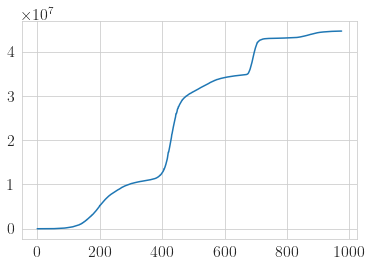

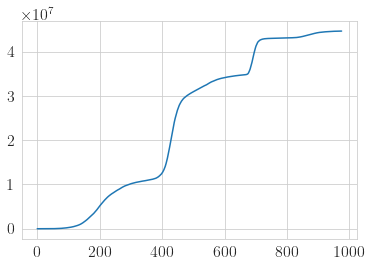

In [6]:
plt.plot(range(len(worldometer_df)), worldometer_df['total_cases_worldometer'])
plt.figure()
plt.plot(range(len(df)), df['total_cases'])

In [7]:
result = pd.merge(df, worldometer_df, on="date")
df = result

In [8]:
print(df.columns)

Index(['date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'gdp_normalized_modelled', 'total_cases_worldometer',
       'total_recovered_worldometer', 'active_cases_worldometer'],
      dtype='object')


In [9]:
df

,date,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled,total_cases_worldometer,total_recovered_worldometer,active_cases_worldometer
0,2020-03-01,10.19,7.0,1.0,0.000000e+00,1.417173e+09,7668.0,98.399973,99.141055,3,3.0,0.0
1,2020-03-02,10.19,5.0,1.0,0.000000e+00,1.417173e+09,7668.0,98.085769,99.141055,6,3.0,3.0
2,2020-03-03,10.19,9.0,1.0,0.000000e+00,1.417173e+09,7668.0,97.771565,99.141055,6,3.0,3.0
3,2020-03-04,10.19,28.0,1.0,0.000000e+00,1.417173e+09,7668.0,97.457362,99.141055,28,3.0,25.0
4,2020-03-05,26.85,29.0,1.0,0.000000e+00,1.417173e+09,7668.0,97.143158,98.881859,30,3.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
971,2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,99.893668,99.006362,44649088,44100691.0,19398.0
972,2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,99.898210,99.006362,44650714,44102852.0,18854.0
973,2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,99.902753,99.006362,44652266,44104933.0,18317.0
974,2022-10-31,31.48,44653592.0,529024.0,2.196409e+09,1.417173e+09,950104356.5,99.907295,99.006362,44653592,44106656.0,17912.0


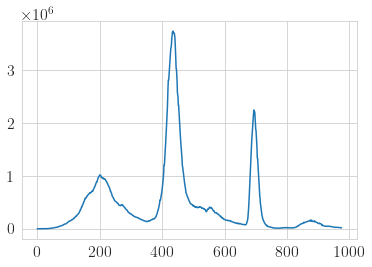

In [10]:
# plt.plot(df['dtotal_cases_worldometer'])
plt.plot(df['active_cases_worldometer'])

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return outliers

In [13]:
print(df.columns)

Index(['date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'gdp_normalized_modelled', 'total_cases_worldometer',
       'total_recovered_worldometer', 'active_cases_worldometer'],
      dtype='object')


## Simple SIR

In [14]:
# df['N'] = df['population']
# df['I'] = df['active_cases']
# df['R'] = df['total_recovered']
# df['S'] =  df['N'] - (df['I'] + df['R'])


# df['N'] = df['population']
# df['I'] = df['total_cases'] - df['total_recovered'] - df['total_deaths']
# df['R'] = df['total_recovered']
# df['S'] = df['N'] - df['I'] - df['R'] - df['people_fully_vaccinated']

# df['N'] = df['population']
# df['I'] = df['total_cases']
# df['R'] = df['total_recovered']
# df['S'] = df['N'] - (df['I'] + df['R'])

# df['N'] = df['population']
# df['I'] = df['total_cases']
# df['R'] = df['total_vaccinations']
# df['S'] = df['N'] - (df['I'] + df['R'])

# df['N'] = df['population']
# df['I'] = df['total_cases_worldometer']
# df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated']
# df['S'] = df['N'] - (df['I'] + df['R'])

# deaths are considered recovered: https://www.kaggle.com/code/lisphilar/covid-19-data-with-sir-model/notebook?scriptVersionId=28560520
df['N'] = df['population']
df['I'] = df['active_cases_worldometer']
df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated'] + df['total_deaths']
df['S'] = df['N'] - (df['I'] + df['R'])

print(detect_outlier(df['S']), detect_outlier(df['I']), detect_outlier(df['R']))

[] [1201456.0, 1200979.0, 1264544.0, 1365674.0, 1475266.0, 1569716.0, 1679716.0, 1801298.0, 1929305.0, 2031957.0, 2156571.0, 2291413.0, 2498999.0, 2681442.0, 2816519.0, 2813658.0, 2882204.0, 2978709.0, 3084814.0, 3170228.0, 3268710.0, 3349644.0, 3413642.0, 3447133.0, 3487229.0, 3603691.0, 3645164.0, 3723446.0, 3736612.0, 3745207.0, 3715188.0, 3704071.0, 3710491.0, 3704860.0, 3673780.0, 3618423.0, 3516976.0, 3353733.0, 3135566.0, 3033071.0, 3027891.0, 2930544.0, 2805369.0, 2594522.0, 2533007.0, 2501662.0, 2338558.0, 2338558.0, 2228724.0, 2114482.0, 2026065.0, 1895506.0, 1793633.0, 1713389.0, 1635976.0, 1555229.0, 1477774.0, 1401566.0, 1304143.0, 1186544.0, 1167933.0, 1121653.0, 1272073.0, 1425581.0, 1550349.0, 1656310.0, 1736605.0, 1830976.0, 1924025.0, 2018799.0, 2113338.0, 2187192.0, 2249287.0, 2236842.0, 2222991.0, 2202443.0, 2105582.0, 2004313.0, 1884918.0, 1858035.0, 1743033.0, 1621582.0, 1533917.0, 1341160.0, 1331619.0, 1224982.0] []


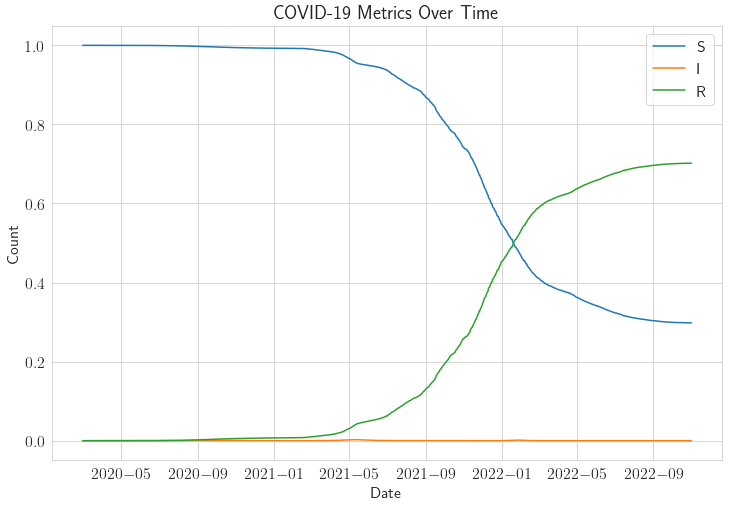

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/df['N'], label='S')
plt.plot(df['date'], df['I']/df['N'], label='I')
plt.plot(df['date'], df['R']/df['N'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [17]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    # mse
    return np.square(data - predictions).mean()

def compute_cost(data, predictions):
    # mae
    return np.abs(data - predictions).mean()

# def compute_cost(data, predictions, delta=1.0):
#     # Huber loss
#     residual = np.abs(data - predictions)
#     condition = residual < delta
#     squared_loss = 0.5 * np.square(residual)
#     linear_loss = delta * (residual - 0.5 * delta)
#     return np.where(condition, squared_loss, linear_loss).mean()

# def compute_cost(data, predictions):
#     # Relative Root Mean Squared Error
#     residual = data - predictions
#     root_mean_squared_error = np.sqrt(np.mean(np.square(residual)))
#     mean_data = np.mean(data)
#     return root_mean_squared_error / mean_data

def compute_cost(data, predictions):
    # mse
    mse = np.square(data - predictions).mean()
    # normalize mse to [0, 1] range
    normalized_mse = mse / (np.max(data)**2)
    return normalized_mse

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [18]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.07, 0.04
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


optimal_beta: 0.07 optimal_gamma: 0.04
optimal_beta/optimal_gamma: 1.7500000000000002


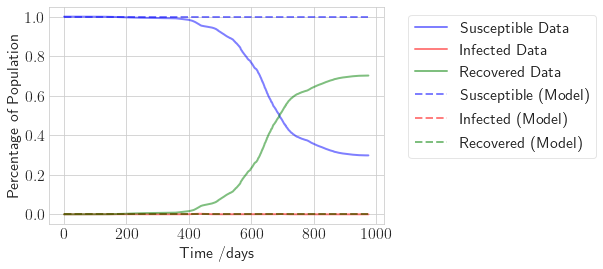

cost_without_lockdown: 0.47015607800897685


In [19]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")


ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_without_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

cost_without_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_without_lockdown: {cost_without_lockdown}")

In [ ]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_without_lockdown"] = S
df["I_modelled_without_lockdown"] = I
df["R_modelled_without_lockdown"] = R
df["r_eff_actual_without_lockdown"] = r0 * df["S"]/df["N"]
df["r_eff_modelled_without_lockdown"] = r0 * df["S_modelled_without_lockdown"]/df["N"]

## SIRV Model

In [ ]:
# df['N'] = df['population']
# df['I'] = df['active_cases']
# df['R'] = df['total_recovered'] + df['people_fully_vaccinated']
# df['S'] =  df['population'] - (df['I'] + df['R'])

df['N'] = df['population']
df['I'] = df['active_cases_worldometer']
df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated'] + df['total_deaths']
df['S'] = df['N'] - (df['I'] + df['R'])

print(detect_outlier(df['S']), detect_outlier(df['I']), detect_outlier(df['R']))

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/df['N'], label='S')
plt.plot(df['date'], df['I']/df['N'], label='I')
plt.plot(df['date'], df['R']/df['N'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [ ]:
def deriv(y, t, N, beta, gamma, nu):
    S, I, R = y
    dSdt = -beta * S * I / N - nu * S
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I + nu * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N):
    beta, gamma, nu = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [ ]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
# initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.3, 1./10, 0.0001
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.3, 1./10, 0.0001 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

In [ ]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma, optimal_nu = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_without_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

cost_without_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_without_lockdown: {cost_without_lockdown}")

## SIRV Model with Lockdown

In [ ]:
def deriv(y, t, N, beta, gamma, nu, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma, nu = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [ ]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.4, 1/15, 0.01 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

In [ ]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma, optimal_nu = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, lockdown))
S, I, R = ret.T

plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time /days')
plt.ylabel('Stringency Index')
plt.grid(True)

cost_with_lockdown = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost_with_lockdown: {cost_with_lockdown}")

In [ ]:
optimal_nu

In [ ]:
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')

## Decrease in cost by modelling Lockdown

In [ ]:
print(f"difference in cost for with/without lockdown: {cost_without_lockdown - cost_with_lockdown}")

In [ ]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [ ]:
print(df.columns)

In [ ]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown"] = S
df["I_modelled_with_lockdown"] = I
df["R_modelled_with_lockdown"] = R
df["r_eff_modelled_with_lockdown"] = r0 * df["S_modelled_with_lockdown"]/df["N"]
df["r_eff_actual_with_lockdown"] = r0 * df["S"]/df["N"]

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(t, df['r_eff_actual_with_lockdown'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_actual_without_lockdown'], 'b', alpha=0.5, lw=2, label='R_eff actual')
plt.plot(t, df['r_eff_modelled_with_lockdown'], 'r', alpha=0.5, lw=2, label='R_eff modelled with lockdown')
plt.plot(t, df['r_eff_modelled_without_lockdown'], 'g', alpha=0.5, lw=2, label='R_eff modelled without lockdown')
plt.legend()

In [ ]:
from scipy.spatial.distance import cosine
print(1 - cosine(df["r_eff_actual_without_lockdown"], df["r_eff_modelled_without_lockdown"]))
print(1 - cosine(df["r_eff_actual_with_lockdown"], df["r_eff_modelled_with_lockdown"]))

In [ ]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [ ]:
df.columns

In [ ]:
print(max(df['gdp_normalized']), min(df['gdp_normalized']))

df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
# here modelled means with gdp modelled with stringency
df['gdp_normalized_modelled_min_max_normalized'] =  (df['gdp_normalized_modelled'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

In [ ]:
plt.plot(df['gdp_min_max_normalized'])
plt.plot(df['gdp_normalized_modelled_min_max_normalized'])

In [ ]:
df.diff()['stringency_index'][1:].describe()

In [ ]:
df['stringency_index'].describe()

In [ ]:
actions_taken = []
# "output/actions_taken/-14154.05.txt"
with open("output/actions_taken/-4372.66.txt", "r") as f:
    for line in f:
        actions_taken.append(int(line.strip()))
start_stringency = 0.0
current_stringency_index = start_stringency
stringency_index_from_actions_taken = [current_stringency_index]
# stringency_index_from_actions_taken = []
diff_list = []
for action in actions_taken:
    reward_inertia_flag = False
    if action == 0:
        current_stringency_index = max(0, current_stringency_index - 10)
        diff = -10
    elif action == 1:
        current_stringency_index = max(0, current_stringency_index - 5)
        diff = -5
    elif action == 2:
        current_stringency_index = max(0, current_stringency_index - 2.5)
        diff = -2.5
    elif action == 3:
        current_stringency_index = max(0, current_stringency_index + 0)
        diff = 0
    elif action == 4:
        current_stringency_index = min(100, current_stringency_index + 2.5)
        diff = 2.5
    elif action == 5:
        current_stringency_index = min(100, current_stringency_index + 5)
        diff = 5
    elif action == 6:
        current_stringency_index = min(100, current_stringency_index + 10)
        diff = 10
    stringency_index_from_actions_taken.append(current_stringency_index)
    diff_list.append(diff)

# stringency_index_from_actions_taken = stringency_index_from_actions_taken + [0]
stringency_index_from_actions_taken = np.array(stringency_index_from_actions_taken)

# the below is a checking mechanism
# stringency_index_from_actions_taken = np.array([0] + list(df['stringency_index']))

In [ ]:
print(actions_taken[:10])

In [ ]:
def calculate_reward_weighted(gdp_normalized_list, r_eff_list):
    GDP_WEIGHT = 5 # change this value and see how it affects the reward
    reward = []
    for i in range(len(gdp_normalized_list)):
        if r_eff_list[i] > 1.5:
            # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
            # print("before", gdp_normalized_list[i] / (5 * r_eff_list[i]))
            reward.append(gdp_normalized_list[i] / (5 * r_eff_list[i]))
        else:
            # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
            # print("after", GDP_WEIGHT * gdp_normalized_list[i])
            reward.append(GDP_WEIGHT * gdp_normalized_list[i])
    return reward

def reward_strategy(stringency_moves, reward_strategy_choosen, sir_technique):   
    N = df.loc[min(df.index), ['N']].item()
    y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
    days_difference = (max(df['date']) - min(df['date'])).days
    t = np.linspace(0, days_difference, days_difference + 1)
    
    stringency_index_random_choice = []
    store_S = np.zeros(days_difference + 1)
    store_I = np.zeros(days_difference + 1)
    store_R = np.zeros(days_difference + 1)

    # sir_technique 1 is faster
    # 2 is just to check whether the results match with 1
    moves_lockdown = stringency_index_from_actions_taken / 100
    if sir_technique == 1:
        moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, moves_lockdown))
        moves_S, moves_I, moves_R = moves_ret.T

        df["S_moves"] = moves_S
        df["I_moves"] = moves_I
        df["R_moves"] = moves_R
    elif sir_technique == 2:
        for ith_day in range(days_difference + 1):
            stringency_index_random_choice.append(stringency_index_from_actions_taken[ith_day])
            t = np.linspace(0, ith_day, ith_day + 1)
            moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, np.array(stringency_index_random_choice) / 100))
            moves_S, moves_I, moves_R = moves_ret.T
            store_S[ith_day] = moves_S[-1]
            store_I[ith_day] = moves_I[-1]
            store_R[ith_day] = moves_R[-1]
        df["S_moves"] = store_S
        df["I_moves"] = store_I
        df["R_moves"] = store_R
    
    df["r_eff_moves_with_lockdown"] = r0 * df["S_moves"]/df["N"]
    df["gdp_normalized_moves_min_max_normalized"] = ((fit_line_loaded(stringency_index_from_actions_taken) - MIN_GDP) / (MAX_GDP - MIN_GDP))[1:]
    
    modelled_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, (df['stringency_index']) / 100))
    modelled_S, modelled_I, modelled_R = modelled_ret.T
    
    df["S_modelled_with_lockdown_inside_plot"] = modelled_S
    df["I_modelled_with_lockdown_inside_plot"] = modelled_I
    df["R_modelled_with_lockdown_inside_plot"] = modelled_R
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["S_modelled_with_lockdown_inside_plot"], color='b', label='S_modelled')
    plt.plot(df["I_modelled_with_lockdown_inside_plot"], color='r', label='I_modelled')
    plt.plot(df["R_modelled_with_lockdown_inside_plot"], color='g', label='R_modelled')
    plt.plot(df["S_moves"], 'b--', label='S_moves')
    plt.plot(df["I_moves"], 'r--', label='I_moves')
    plt.plot(df["R_moves"], 'g--', label='R_moves')
    plt.xlabel('days')
    plt.ylabel('Population')
    plt.title('SIR_dynamics')
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['stringency_index'], color='b', label='actual')
    plt.plot(stringency_index_from_actions_taken , color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('stringency')
    plt.title('stringency')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['r_eff_actual_with_lockdown'], color='b', label='actual')
    plt.plot(df['r_eff_modelled_with_lockdown'], color='r', label='modelled')
    plt.plot(df['r_eff_moves_with_lockdown'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('r_eff')
    plt.title('R_eff')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['gdp_min_max_normalized'], color='b', label='actual')
    plt.plot(df['gdp_normalized_modelled_min_max_normalized'], color='r', label='modelled')
    plt.plot(df['gdp_normalized_moves_min_max_normalized'], color='g', label='moves')
    plt.xlabel('days')
    plt.ylabel('gdp')
    plt.title('GDP')
    plt.legend()
    plt.show()
        
    if reward_strategy_choosen == 1:
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'])))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"], color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"], color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'])))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color='g', label='reward(modelled) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 2:
        plt.figure(figsize=(10, 6))
        
        index_to_the_power_of = 0.001
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='b', label='reward(actual) = {reward}'.format(reward = np.sum(df['gdp_min_max_normalized'] / df['r_eff_actual_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(df['gdp_normalized_modelled_min_max_normalized'] / df['r_eff_modelled_with_lockdown'] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color='g', label='reward(moves) = {reward}'.format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 3:
        
        # we need the epidemic to happen and also the I population to stay below a certain value (beds in the hospital) (10 multiple)
        # we need r_eff to be below 1 at an earlier stage (1 multiple)
        # we need to reward inertia by a small amount (0.1 multiple)
        
        hospital_capacity = 0.082
        hospital_capacity_reward = -100
        # reward_I_percentage = -100 if self.I_proportion >= 0.082 else 0
        I_reward_actual = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I"] / df["N"]]
        I_reward_modelled = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I_modelled_with_lockdown"] / N]
        I_reward_moves = [hospital_capacity_reward if I_percentage >= hospital_capacity else 0 for I_percentage in df["I_moves"] / N]
        
        r_eff_reward_choosen = 1
        r_eff_punishment_choosen = -1
        r_eff_level = 1.8
        r_eff_reward_actual = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_actual_with_lockdown"]]
        r_eff_reward_modelled = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_modelled_with_lockdown"]]
        r_eff_reward_moves = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_moves_with_lockdown"]]
        
        inertia_rewards_actual = [0] + [abs(diff)*2*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        # modelled reward for intertia is same as actual
        inertia_rewards_modelled = [0] + [abs(diff)*2*-1 for diff in (df['stringency_index'][i] - df['stringency_index'][i - 1] for i in range(1, len(df)))]
        inertia_rewards_moves = [abs(diff)*2*-1 for diff in (stringency_index_from_actions_taken[i] - stringency_index_from_actions_taken[i - 1] for i in range(1, len(stringency_index_from_actions_taken)))]
        
        # index_to_the_power_of = 0.00001
        # reward_actual = (df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        # reward_modelled = (df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        # reward_moves = (df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        # TODO try this...
        """
        def calculate_reward(gdp_normalized, r_eff_actual):
            GDP_WEIGHT = 0.35 # change this value and see how it affects the reward
            if r_eff_actual > 1:
                # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
                return gdp_normalized / (5 * r_eff_actual)
            else:
                # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
                return GDP_WEIGHT * gdp_normalized
        """
        
        reward_actual = calculate_reward_weighted(df["gdp_min_max_normalized"], df["r_eff_actual_with_lockdown"]) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        reward_modelled = calculate_reward_weighted(df["gdp_normalized_modelled_min_max_normalized"], df["r_eff_modelled_with_lockdown"]) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        reward_moves = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_with_lockdown"]) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        rl_reward_moves = reward_moves
        rl_reward_weighted = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_with_lockdown"])
        rl_reward_I_percentage = I_reward_moves
        rl_reward_r_eff = r_eff_reward_moves
        rl_reward_inertia = inertia_rewards_moves

        plt.plot(reward_actual, color='b', label='reward(actual) = {reward}'.format(reward = np.sum(reward_actual)))
        plt.plot(reward_modelled, color='r', label='reward(modelled) = {reward}'.format(reward = np.sum(reward_modelled)))
        plt.plot(reward_moves, color='g', label='reward(moves) = {reward}'.format(reward = np.sum(reward_moves)))
        plt.xlabel('days')
        plt.ylabel('reward')
        plt.title('reward')
        plt.legend()
        plt.show()
        
        return rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia

In [ ]:
rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia = reward_strategy(stringency_index_from_actions_taken, reward_strategy_choosen=3, sir_technique=1)

In [ ]:
for I in df["I_modelled_with_lockdown"] / N:
    if I > 0.08:
        print("yes - 0.08")

for I in df["I_modelled_with_lockdown"] / N:
    if I > 0.10:
        print("yes - 0.10")

In [ ]:
print(max(df["I"] / df["N"]))

In [ ]:
print(max(df["I_modelled_with_lockdown"] / df["N"]))

## Double checking Calculation

In [ ]:
# print(rl_reward_moves, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia, rl_reward_weighted)

info_saved_df = pd.read_csv("output/info_save/-14233.67.csv")
for i in range(0, 1033):
    print(rl_reward_inertia[i], info_saved_df.iloc[i]['reward_inertia'])

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_inertia']), "outside_rl:", np.sum(rl_reward_inertia))

plt.figure(figsize=(10, 6))
plt.plot(list(info_saved_df['reward_inertia'][200:350]), 'r', label='inside_rl')
plt.plot(list(rl_reward_inertia[200:350]), 'g', label='outside_rl')
plt.legend()

In [ ]:
plt.plot(info_saved_df['stringency_index'][:150], 'r', label='inside_rl')
plt.plot(stringency_index_from_actions_taken[:150], 'g', label='outside_rl')
plt.legend()

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_r_eff']), "outside_rl:",  np.sum(rl_reward_r_eff))
plt.plot(info_saved_df['reward_r_eff'][:250], 'r', label='inside_rl')
plt.plot(rl_reward_r_eff[:250], 'g', label='outside_rl')
plt.legend()

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_I_percentage']), "outside_rl:", np.sum(rl_reward_I_percentage))
plt.plot(info_saved_df['reward_I_percentage'][:200], 'r', label='inside_rl')
plt.plot(rl_reward_I_percentage[:200], 'g', label='outside_rl')

In [ ]:
print("inside_rl:", np.sum(info_saved_df['reward_weigthed']), "outside_rl:", np.sum(rl_reward_weighted))
plt.plot(info_saved_df['reward_weigthed'][:200], 'r', label='inside_rl')
plt.plot(rl_reward_weighted[:200], 'g', label='outside_rl')